# Exploring time varying dynamics

Recall that with differential dynamic microscopy, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y;t) - I(x,y;t + \Delta t)$$ For a given $\Delta t$ all such image differences are calculated. For typical DDM analysis, we then Fourier transform each $\Delta I$ and **average all of the same $\Delta t$**.

However, if the dynamics are varying over time, then we might **not** want to average over all times. We instead might want to have a DDM matrix which is a function of lagtime and time (and wavevector too).

## Importing the necessary modules

### Modules for plotting
We use [matplotlib](https://matplotlib.org/) for creating figures and plots. Note that we use:
```python
%matplotlib inline
```
This sets the backend of matplotlib to `inline` which means the plots are included in the notebook. If you want the plots to also be interactive (e.g., having the ability to zoom, scroll, and save) then use:
```python
%matplotlib notebook
```

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Modules for numerical work
Here, we import [numpy](https://numpy.org/) and [xarray](https://xarray.pydata.org/en/stable/). 

Note that `xarray` might not have come with your Anaconda Python distribution (or whichever other distribution you installed). If that is the case, you'll need to [install](https://xarray.pydata.org/en/stable/getting-started-guide/installing.html) this package. 

In [2]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

### Import the PyDDM package
Make sure you append to `sys.path` the directory containing the [PyDDM](https://rmcgorty.github.io/PyDDM/) code. 

In [3]:
import sys
sys.path.append("../PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

## Initializing DDM_Analysis class and computing the DDM matrix
The instance of the `DDM_Analysis` class we create will need, when initialized, metadata about the images to analyze and the analysis and fitting parameters. This can be done by using a [yaml](https://yaml.org/) file as shown in the following cell of code (there, the metadata is saved in the file "*example_data_silica_beads.yml*". 

In [4]:
#The yaml file `example_data_silica_beads.yml` contains the metadata and parameters above
#Note that here we *are* applying a 2x2 binning

ddm_calc = ddm.DDM_Analysis("example_data_silica_beads.yml")

Provided metadata: {'pixel_size': 0.242, 'frame_rate': 41.7}
Image shape: 3000-by-128-by-128
Number of frames to use for analysis: 999
Maximum lag time (in frames): 600
Number of lag times to compute DDM matrix: 40
Applying binning...
Dimensions after binning (999, 64, 64), the new pixel size 0.484


Below, with the method `calculate_DDM_matrix`, we compute the DDM matrix and some associated data. The data will be stored as an [xarray Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html) as an attribute to `ddm_calc` called `ddm_dataset`.

**Note**: There are a few optional arguments we can pass to `calculate_DDM_matrix`. There is an optional argument `quiet` (*True* or *False*, *False* by default). Then we have some optional keyword arguments (all of which could also be specified in the YAML file). These are: `overlap_method` which sets the degree of overlap between image pairs when finding all image differences for a each lag time and is either *0*, *1*, *2*, or *3*, `background_method` which sets how to estimate the background parameter *B* and is either *0*, *1*, *2*, or *3*, and `number_lag_times`. If any of these three keyword arguments are set here, the value specified in the YAML file will be overwritten. 

In [5]:
#If a file is found that matches what, by default, the program will save the computed DDM matrix as, 
#then you will be prompted as to whether or not you want to proceed with this calculation. If you 
#do not, then enter 'n' and the program will read from the existing file to load the DDM dataset 
#into memory. If you enter 'y', then the DDM matrix will be calculated.

ddm_calc.calculate_DDM_matrix()

The file C:/Users/rmcgorty/Documents/GitHub/PyDDM/Examples/images_nobin_40x_128x128_8bit_ddmmatrix.nc already exists. So perhaps the DDM matrix was calculated already?
Do you still want to calculate the DDM matrix? (y/n): n


## Finding variability in the DDM matrix

When computing the DDM matrix, we average over all pairs of images separated by the given set of lag times. For example, for a lag time of 2 frames, we will find the differences between frames 1 and 3, 2 and 4, 3 and 5, etc. The power spectrum of those differences are then taken to yield the DDM matrix. But what if the dynamics in the sample are changing? For example, perhaps the difference between frames 1 and 3 will be very different from the difference between frames 1001 and 1003. 

In [6]:
tlags = np.arange(1,998,dtype=int) #We will compute the DDM matrix for all lag times from 1 frame to 998 frames

#With the function 'variationInDDMMatrix', we compute the DDM matrix for the given lag times
# **without** doing any averaging over time. With the optional paramter 'save_full_ddmmat' set to 
# False, we will be radially averaging the 2D DDM matrix. This will save memory. 
ddm_variability = ddm_calc.variationInDDMMatrix(tlags, save_full_ddmmat=False)

In [68]:
ddm_variability.to_netcdf("ddm_variability_silicabeads.nc") #save generated dataset to disk

In [7]:
ddm_variability

<xarray.Dataset>
Dimensions:           (lagtime: 997, time: 998, q: 32)
Coordinates:
  * time              (time) float64 0.0 0.02398 0.04796 ... 23.86 23.88 23.91
  * lagtime           (lagtime) int32 1 2 3 4 5 6 7 ... 992 993 994 995 996 997
  * q                 (q) float64 0.0 0.2028 0.4057 0.6085 ... 5.882 6.085 6.288
Data variables:
    ddm_matrix        (lagtime, time, q) float64 0.0 220.0 184.4 ... nan nan nan
    alignment_factor  (lagtime, time, q) float64 nan 6.123e-17 ... nan nan
Attributes:
    AlignmentFactorAxis:  0

In [9]:
q_index_of_twotimecorrelation = 10
print("Calculating the two-time correlation for q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index_of_twotimecorrelation])
twotimecorr = ddm_calc.createTwoTimeCorr(ddm_variability,q_index_of_twotimecorrelation)

Calculating the two-time correlation for q = 2.03 $\mu$m$^{-1}$


Text(0, 0.5, 'Frame 1')

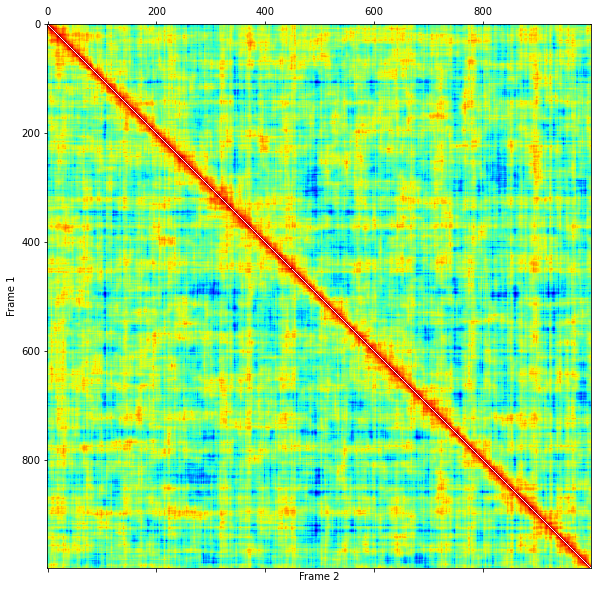

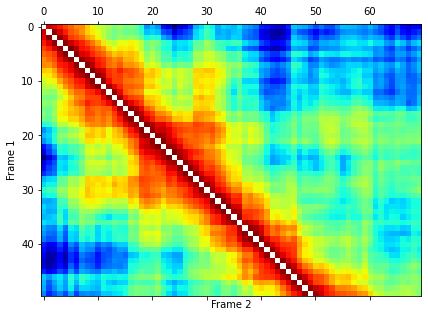

In [12]:
plt.figure(figsize=(10,10))
plt.matshow(twotimecorr, cmap='jet_r', fignum=0)
plt.xlabel("Frame 2")
plt.ylabel("Frame 1")

plt.figure(figsize=(8,5))
plt.matshow(twotimecorr[0:50,0:70], cmap='jet_r', fignum=0)
plt.xlabel("Frame 2")
plt.ylabel("Frame 1")

Text(0, 0.5, 'DDM Matrix')

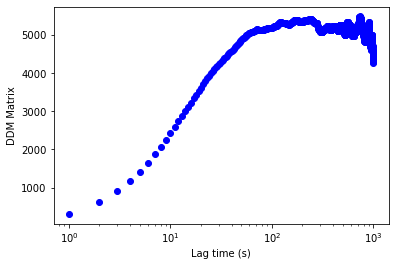

In [15]:
#Averaging over all time...

fig,ax = plt.subplots()
ax.semilogx(ddm_variability.lagtime, ddm_variability.ddm_matrix[:,:,q_index_of_twotimecorrelation].mean(axis=1),'bo')
ax.set_xlabel("Lag time (s)")
ax.set_ylabel("DDM Matrix")

In [17]:

q_index = 10

variations = np.empty((len(ddm_variability.lagtime), len(ddm_variability.time)))
variations.fill(np.nan)

skewnesses = np.empty(len(ddm_variability.lagtime))

for i in range(len(ddm_variability.lagtime)):
    variations[i] = ddm_variability.ddm_matrix[i,:,q_index] - np.nanmean(ddm_variability.ddm_matrix[i,:,q_index])
    skewnesses[i] = np.nanmean(variations[i]**3) / (np.nanmean(variations[i]**2)**1.5)


Text(0.5, 1.0, 'q = 2.03 $\\mu$m$^{-1}$')

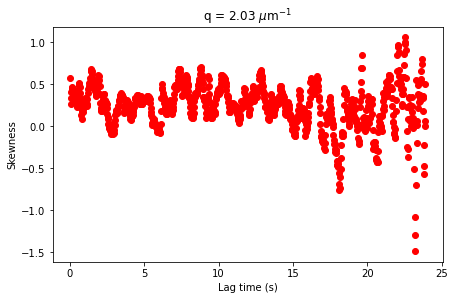

In [21]:
fig,ax = plt.subplots(figsize = (7,7/1.618))
ax.plot(ddm_variability.lagtime / 41.7, skewnesses, 'ro')
ax.set_xlabel("Lag time (s)")
ax.set_ylabel("Skewness")
ax.set_title("q = %.2f $\mu$m$^{-1}$" % ddm_variability.q[q_index])

Skewness: 1.0917


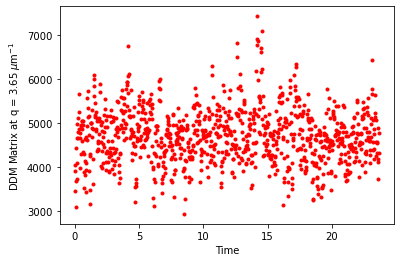

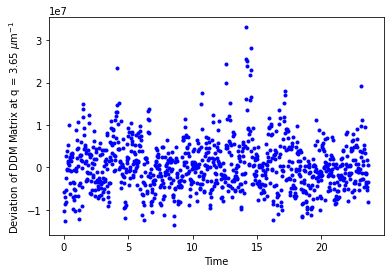

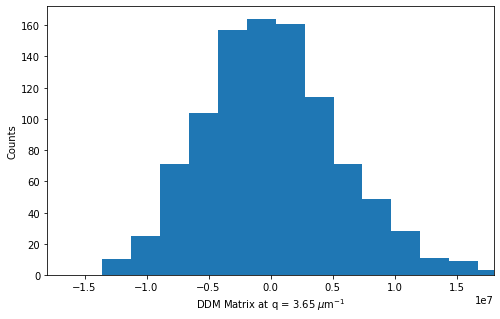

In [22]:
fig,ax = plt.subplots()
q_index = 18
lagtimeindex = 10
ax.plot(ddm_variability.time, ddm_variability.ddm_matrix[lagtimeindex,:,q_index], 'r.')

ax.set_xlabel("Time")
ax.set_ylabel("DDM Matrix at q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index])

fig,ax = plt.subplots()

variation = ddm_variability.ddm_matrix[lagtimeindex,:,q_index]**2 - np.mean(ddm_variability.ddm_matrix[lagtimeindex,:,q_index])**2
ax.plot(ddm_variability.time, variation, 'b.')
ax.set_xlabel("Time")
ax.set_ylabel("Deviation of DDM Matrix at q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index])

fig,ax = plt.subplots(figsize = (8,8/1.618))
plt.hist(variation, bins=20)
ax.set_xlabel("DDM Matrix at q = %.2f $\mu$m$^{-1}$" % ddm_calc.q[q_index])
ax.set_ylabel("Counts")
ax.set_xlim(-1.8e7,1.8e7)
plt.savefig("DDMMat_hist_q18_lag10.png")

skewness = np.mean(variation**3) / (np.mean(variation**2)**1.5)
print("Skewness: %.4f" % skewness)